In [1]:
# general functions
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import OrderedDict
# visualization
from PIL import Image

# visualizing bounding boxes
import matplotlib.patches as patches
# CNN
import keras
from sklearn.model_selection import train_test_split
# Moving files between directories
import shutil
from shutil import unpack_archive
from subprocess import check_output

Using TensorFlow backend.
C:\Users\Laide\anaconda3\envs\python3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Laide\anaconda3\envs\python3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Laide\anaconda3\envs\python3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Laide\anaconda3\envs\pytho

In [2]:
from keras.initializers import he_normal
from keras_preprocessing.image import ImageDataGenerator
import time
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.core import Dense, Activation, Lambda, Flatten

import utils
from utils import LRN2D

import os.path
import warnings
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [8, 4]
warnings.filterwarnings("ignore", category=FutureWarning)
%config InlineBackend.figure_format = 'retina'

In [3]:
dataset_path = "../datasets/lfw-deepfunneled/lfw-deepfunneled/"

In [4]:
# Data read-in and cleaning

lfw_allnames = pd.read_csv("../datasets/lfw_allnames.csv")
matchpairsDevTest = pd.read_csv("../datasets/matchpairsDevTest.csv")
matchpairsDevTrain = pd.read_csv("../datasets/matchpairsDevTrain.csv")
mismatchpairsDevTest = pd.read_csv("../datasets/mismatchpairsDevTest.csv")
mismatchpairsDevTrain = pd.read_csv("../datasets/mismatchpairsDevTrain.csv")
pairs = pd.read_csv("../datasets/pairs.csv")

In [5]:
# tidy pairs data: 
pairs = pairs.rename(columns ={'name': 'name1', 'Unnamed: 3': 'name2'})
matched_pairs = pairs[pairs["name2"].isnull()].drop("name2",axis=1)
mismatched_pairs = pairs[pairs["name2"].notnull()]
people = pd.read_csv("../datasets/people.csv")

In [6]:
# remove null values
people = people[people.name.notnull()]
peopleDevTest = pd.read_csv("../datasets/peopleDevTest.csv")
peopleDevTrain = pd.read_csv("../datasets/peopleDevTrain.csv")

In [7]:
print("Summary:")
print("There are " + 
    str(lfw_allnames.shape[0]) + 
    " unique celebrities in the entire dataset, of whom " + 
    str(sum(lfw_allnames.images > 1)) + 
    "\nare represented by multiple images. The entire number of images available is " + 
    str(sum(lfw_allnames.images)) + 
    ".\nThe most represented celebrity is " + 
    str(lfw_allnames.iloc[lfw_allnames['images'].idxmax()][0]) + 
    ", with " + 
    str(max(lfw_allnames.images)) + 
" unique images in the dataset.")

Summary:
There are 5749 unique celebrities in the entire dataset, of whom 1680
are represented by multiple images. The entire number of images available is 13233.
The most represented celebrity is George_W_Bush, with 530 unique images in the dataset.


In [8]:
# shape data frame so there is a row per image, matched to relevant jpg file
image_paths = lfw_allnames.loc[lfw_allnames.index.repeat(lfw_allnames['images'])]
image_paths['image_path'] = 1 + image_paths.groupby('name').cumcount()
image_paths['image_path'] = image_paths.image_path.apply(lambda x: '{0:0>4}'.format(x))
image_paths['image_path'] = image_paths.name + "/" + image_paths.name + "_" + image_paths.image_path + ".jpg"
image_paths = image_paths.drop("images",1)

# take a random sample: 60% of the data for the train set 20% for test and val
lfw_train, lfw_test = train_test_split(image_paths, test_size=0.2, random_state=1)
lfw_train, lfw_val = train_test_split(lfw_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2


lfw_train = lfw_train.reset_index().drop("index",1)
lfw_test = lfw_test.reset_index().drop("index",1)
lfw_val = lfw_test.reset_index().drop("index",1)

In [9]:
# verify that there is a mix of seen and unseen individuals in the test and val set
print(len(set(lfw_train.name).intersection(set(lfw_test.name))))
print(len(set(lfw_test.name) - set(lfw_train.name)))
print(len(set(lfw_val.name) - set(lfw_train.name)))

734
899
899


In [10]:
# verify resolution of all images is consistent
widths = []
heights = []
files = image_paths.image_path
for file in files:
    path = "../datasets/lfw-deepfunneled/lfw-deepfunneled/" + str(file)
    im = Image.open(path)
    widths.append(im.width)
    heights.append(im.height)

In [11]:
# all 250 x 250 resolution
pd.DataFrame({'height':heights,'width':widths}).describe()

,height,width
count,13233.0,13233.0
mean,250.0,250.0
std,0.0,0.0
min,250.0,250.0
25%,250.0,250.0
50%,250.0,250.0
75%,250.0,250.0
max,250.0,250.0


#### LFW dataset is significantly imbalance. We will use selective sampling to handle this.

<AxesSubplot:>

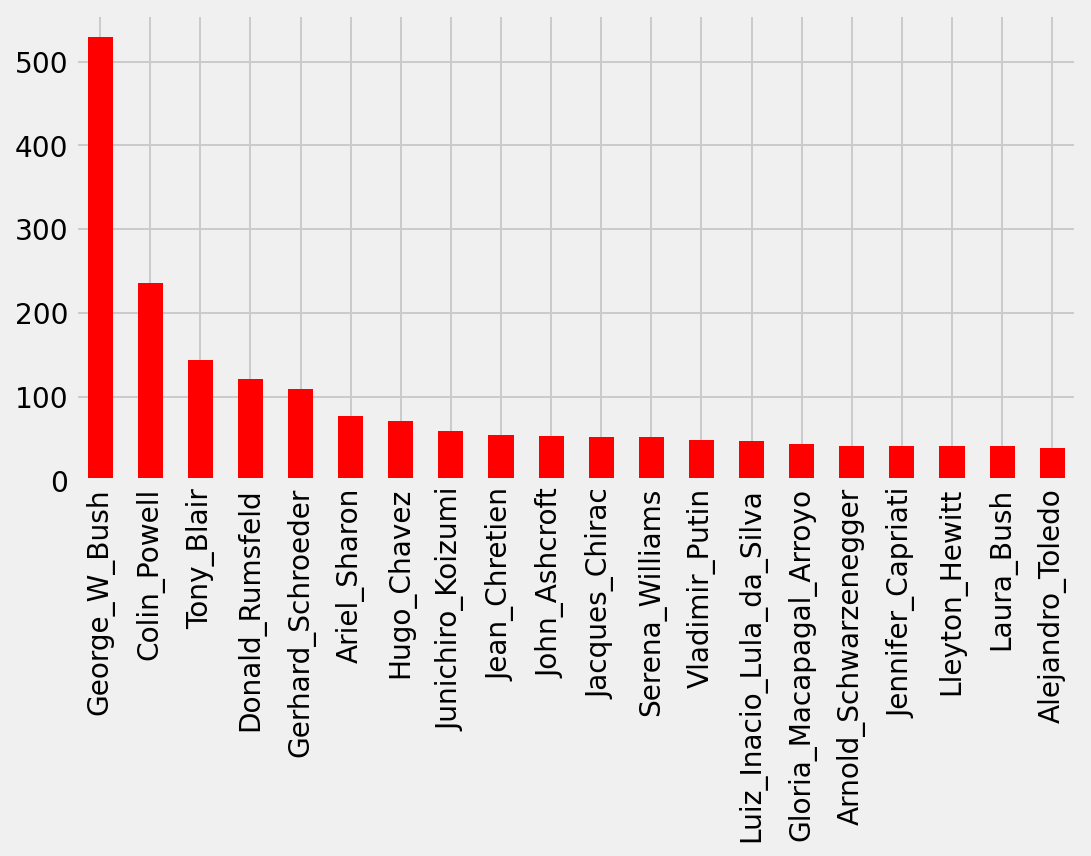

In [10]:
#Evidence for the imbalanced dataset

image_paths['name'].value_counts()[:20].plot(kind = "bar", stacked=True, color='red')

In [11]:
ind_counts = image_paths.groupby('name').count().image_path
print(str(sum(ind_counts[ind_counts==1])) + " individuals, which is " + str(round(100*(sum(ind_counts[ind_counts==1])/sum(ind_counts)))) + "%\nof the total individuals considered, are only represented by a single image in this dataset.")

4069 individuals, which is 31%
of the total individuals considered, are only represented by a single image in this dataset.


we visualize a sample image to confirm that all directories are corretly connected

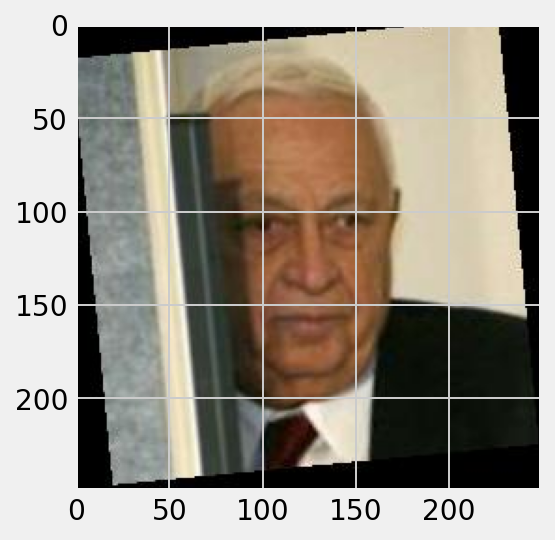

In [12]:
im = Image.open("../datasets/lfw-deepfunneled/lfw-deepfunneled/" + str(lfw_train.image_path[2]))
plt.imshow(im)

In [12]:
# Setting the input size now to 96 x 96 pixel 
img_rows = 96
img_cols = 96 

In [13]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_cols, img_rows) 
else:
    input_shape = (img_cols, img_rows, 3)

In [14]:
def model_creator(top_model):
    myInput = Input(shape=(img_rows, img_cols, 3))

    x = ZeroPadding2D(padding=(3, 3), input_shape=(img_rows, img_cols, 3))(myInput)
    x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
    x = BatchNormalization(axis=3, epsilon=0.00001, name='bn1')(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = MaxPooling2D(pool_size=3, strides=2)(x)
    x = Lambda(LRN2D, name='lrn_1')(x)
    x = Conv2D(64, (1, 1), name='conv2')(x)
    x = BatchNormalization(axis=3, epsilon=0.00001, name='bn2')(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = Conv2D(192, (3, 3), name='conv3')(x)
    x = BatchNormalization(axis=3, epsilon=0.00001, name='bn3')(x)
    x = Activation('relu')(x)
    x = Lambda(LRN2D, name='lrn_2')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = MaxPooling2D(pool_size=3, strides=2)(x)

    # Inception3a
    inception_3a_3x3 = Conv2D(96, (1, 1), name='inception_3a_3x3_conv1')(x)
    inception_3a_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_3x3_bn1')(inception_3a_3x3)
    inception_3a_3x3 = Activation('relu')(inception_3a_3x3)
    inception_3a_3x3 = ZeroPadding2D(padding=(1, 1))(inception_3a_3x3)
    inception_3a_3x3 = Conv2D(128, (3, 3), name='inception_3a_3x3_conv2')(inception_3a_3x3)
    inception_3a_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_3x3_bn2')(inception_3a_3x3)
    inception_3a_3x3 = Activation('relu')(inception_3a_3x3)

    inception_3a_5x5 = Conv2D(16, (1, 1), name='inception_3a_5x5_conv1')(x)
    inception_3a_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_5x5_bn1')(inception_3a_5x5)
    inception_3a_5x5 = Activation('relu')(inception_3a_5x5)
    inception_3a_5x5 = ZeroPadding2D(padding=(2, 2))(inception_3a_5x5)
    inception_3a_5x5 = Conv2D(32, (5, 5), name='inception_3a_5x5_conv2')(inception_3a_5x5)
    inception_3a_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_5x5_bn2')(inception_3a_5x5)
    inception_3a_5x5 = Activation('relu')(inception_3a_5x5)

    inception_3a_pool = MaxPooling2D(pool_size=3, strides=2)(x)
    inception_3a_pool = Conv2D(32, (1, 1), name='inception_3a_pool_conv')(inception_3a_pool)
    inception_3a_pool = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_pool_bn')(inception_3a_pool)
    inception_3a_pool = Activation('relu')(inception_3a_pool)
    inception_3a_pool = ZeroPadding2D(padding=((3, 4), (3, 4)))(inception_3a_pool)

    inception_3a_1x1 = Conv2D(64, (1, 1), name='inception_3a_1x1_conv')(x)
    inception_3a_1x1 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_1x1_bn')(inception_3a_1x1)
    inception_3a_1x1 = Activation('relu')(inception_3a_1x1)

    inception_3a = concatenate([inception_3a_3x3, inception_3a_5x5, inception_3a_pool, inception_3a_1x1], axis=3)

    # Inception3b
    inception_3b_3x3 = Conv2D(96, (1, 1), name='inception_3b_3x3_conv1')(inception_3a)
    inception_3b_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_3x3_bn1')(inception_3b_3x3)
    inception_3b_3x3 = Activation('relu')(inception_3b_3x3)
    inception_3b_3x3 = ZeroPadding2D(padding=(1, 1))(inception_3b_3x3)
    inception_3b_3x3 = Conv2D(128, (3, 3), name='inception_3b_3x3_conv2')(inception_3b_3x3)
    inception_3b_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_3x3_bn2')(inception_3b_3x3)
    inception_3b_3x3 = Activation('relu')(inception_3b_3x3)

    inception_3b_5x5 = Conv2D(32, (1, 1), name='inception_3b_5x5_conv1')(inception_3a)
    inception_3b_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_5x5_bn1')(inception_3b_5x5)
    inception_3b_5x5 = Activation('relu')(inception_3b_5x5)
    inception_3b_5x5 = ZeroPadding2D(padding=(2, 2))(inception_3b_5x5)
    inception_3b_5x5 = Conv2D(64, (5, 5), name='inception_3b_5x5_conv2')(inception_3b_5x5)
    inception_3b_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_5x5_bn2')(inception_3b_5x5)
    inception_3b_5x5 = Activation('relu')(inception_3b_5x5)

    inception_3b_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_3a)
    inception_3b_pool = Conv2D(64, (1, 1), name='inception_3b_pool_conv')(inception_3b_pool)
    inception_3b_pool = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_pool_bn')(inception_3b_pool)
    inception_3b_pool = Activation('relu')(inception_3b_pool)
    inception_3b_pool = ZeroPadding2D(padding=(4, 4))(inception_3b_pool)

    inception_3b_1x1 = Conv2D(64, (1, 1), name='inception_3b_1x1_conv')(inception_3a)
    inception_3b_1x1 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_1x1_bn')(inception_3b_1x1)
    inception_3b_1x1 = Activation('relu')(inception_3b_1x1)

    inception_3b = concatenate([inception_3b_3x3, inception_3b_5x5, inception_3b_pool, inception_3b_1x1], axis=3)

    # Inception3c
    inception_3c_3x3 = utils.conv2d_bn(inception_3b,
                                       layer='inception_3c_3x3',
                                       cv1_out=128,
                                       cv1_filter=(1, 1),
                                       cv2_out=256,
                                       cv2_filter=(3, 3),
                                       cv2_strides=(2, 2),
                                       padding=(1, 1))

    inception_3c_5x5 = utils.conv2d_bn(inception_3b,
                                       layer='inception_3c_5x5',
                                       cv1_out=32,
                                       cv1_filter=(1, 1),
                                       cv2_out=64,
                                       cv2_filter=(5, 5),
                                       cv2_strides=(2, 2),
                                       padding=(2, 2))

    inception_3c_pool = MaxPooling2D(pool_size=3, strides=2)(inception_3b)
    inception_3c_pool = ZeroPadding2D(padding=((0, 1), (0, 1)))(inception_3c_pool)

    inception_3c = concatenate([inception_3c_3x3, inception_3c_5x5, inception_3c_pool], axis=3)

    #inception 4a
    inception_4a_3x3 = utils.conv2d_bn(inception_3c,
                                       layer='inception_4a_3x3',
                                       cv1_out=96,
                                       cv1_filter=(1, 1),
                                       cv2_out=192,
                                       cv2_filter=(3, 3),
                                       cv2_strides=(1, 1),
                                       padding=(1, 1))
    inception_4a_5x5 = utils.conv2d_bn(inception_3c,
                                       layer='inception_4a_5x5',
                                       cv1_out=32,
                                       cv1_filter=(1, 1),
                                       cv2_out=64,
                                       cv2_filter=(5, 5),
                                       cv2_strides=(1, 1),
                                       padding=(2, 2))

    inception_4a_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_3c)
    inception_4a_pool = utils.conv2d_bn(inception_4a_pool,
                                        layer='inception_4a_pool',
                                        cv1_out=128,
                                        cv1_filter=(1, 1),
                                        padding=(2, 2))
    inception_4a_1x1 = utils.conv2d_bn(inception_3c,
                                       layer='inception_4a_1x1',
                                       cv1_out=256,
                                       cv1_filter=(1, 1))
    inception_4a = concatenate([inception_4a_3x3, inception_4a_5x5, inception_4a_pool, inception_4a_1x1], axis=3)

    #inception4e
    inception_4e_3x3 = utils.conv2d_bn(inception_4a,
                                       layer='inception_4e_3x3',
                                       cv1_out=160,
                                       cv1_filter=(1, 1),
                                       cv2_out=256,
                                       cv2_filter=(3, 3),
                                       cv2_strides=(2, 2),
                                       padding=(1, 1))
    inception_4e_5x5 = utils.conv2d_bn(inception_4a,
                                       layer='inception_4e_5x5',
                                       cv1_out=64,
                                       cv1_filter=(1, 1),
                                       cv2_out=128,
                                       cv2_filter=(5, 5),
                                       cv2_strides=(2, 2),
                                       padding=(2, 2))
    inception_4e_pool = MaxPooling2D(pool_size=3, strides=2)(inception_4a)
    inception_4e_pool = ZeroPadding2D(padding=((0, 1), (0, 1)))(inception_4e_pool)

    inception_4e = concatenate([inception_4e_3x3, inception_4e_5x5, inception_4e_pool], axis=3)

    #inception5a
    inception_5a_3x3 = utils.conv2d_bn(inception_4e,
                                       layer='inception_5a_3x3',
                                       cv1_out=96,
                                       cv1_filter=(1, 1),
                                       cv2_out=384,
                                       cv2_filter=(3, 3),
                                       cv2_strides=(1, 1),
                                       padding=(1, 1))

    inception_5a_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_4e)
    inception_5a_pool = utils.conv2d_bn(inception_5a_pool,
                                        layer='inception_5a_pool',
                                        cv1_out=96,
                                        cv1_filter=(1, 1),
                                        padding=(1, 1))
    inception_5a_1x1 = utils.conv2d_bn(inception_4e,
                                       layer='inception_5a_1x1',
                                       cv1_out=256,
                                       cv1_filter=(1, 1))

    inception_5a = concatenate([inception_5a_3x3, inception_5a_pool, inception_5a_1x1], axis=3)

    #inception_5b
    inception_5b_3x3 = utils.conv2d_bn(inception_5a,
                                       layer='inception_5b_3x3',
                                       cv1_out=96,
                                       cv1_filter=(1, 1),
                                       cv2_out=384,
                                       cv2_filter=(3, 3),
                                       cv2_strides=(1, 1),
                                       padding=(1, 1))
    inception_5b_pool = MaxPooling2D(pool_size=3, strides=2)(inception_5a)
    inception_5b_pool = utils.conv2d_bn(inception_5b_pool,
                                        layer='inception_5b_pool',
                                        cv1_out=96,
                                        cv1_filter=(1, 1))
    inception_5b_pool = ZeroPadding2D(padding=(1, 1))(inception_5b_pool)

    inception_5b_1x1 = utils.conv2d_bn(inception_5a,
                                       layer='inception_5b_1x1',
                                       cv1_out=256,
                                       cv1_filter=(1, 1))
    inception_5b = concatenate([inception_5b_3x3, inception_5b_pool, inception_5b_1x1], axis=3)

    av_pool = AveragePooling2D(pool_size=(3, 3), strides=(1, 1))(inception_5b)
    reshape_layer = Flatten()(av_pool)
    dense_layer = Dense(units = 128, activation = 'relu')(reshape_layer)
    norm_layer = Dense(units = 1, activation = 'sigmoid')(dense_layer)

    return Model(inputs=[myInput], outputs=norm_layer)

#### Load openface on the created layer above

In [15]:
conv_base=model_creator('./open_face.h5')

In [16]:
config = conv_base.get_config() # Returns pretty much every information about your model
print(config["layers"][0]["config"]["batch_input_shape"]) # returns a tuple of width, height and channels

(None, 96, 96, 3)


In [17]:
print(conv_base.summary())
print('No. of hidden layers after addition of extra layers= {}'.format(len(conv_base.layers)))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 102, 102, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 48, 48, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [18]:
not_bush = image_paths[image_paths.name!="George_W_Bush"].sample(530)
not_bush.name = "not_bush"
GWB_data = pd.concat([image_paths[image_paths.name=="George_W_Bush"],
                     not_bush])

#### Train, Test and Validation Split of the Subset of LFW dataset

In [21]:
gb_train, gb_test = train_test_split(GWB_data, test_size=0.2, random_state=1)
gb_train, gb_val = train_test_split(gb_train,test_size=0.25, random_state=1)

In [22]:
# define a custom function to move images to a new train/test/val directory

def dir_arranger(data,dir_name):
    co = 0
    for image in data.image_path:
        # create top directory
        parent_dir = r"..\datasets\split"
        if not os.path.exists(os.path.join(parent_dir,dir_name)):
            shutil.os.mkdir(os.path.join(parent_dir,dir_name))
        data_type = data[data['image_path'] == image]['name']
        data_type = str(list(data_type)[0])
        if not os.path.exists(os.path.join(parent_dir,dir_name,data_type)):
            shutil.os.mkdir(os.path.join(parent_dir,dir_name,data_type))
        path_from = os.path.join('../datasets/lfw-deepfunneled/lfw-deepfunneled/',image)
        path_to = os.path.join(parent_dir,dir_name,data_type)
        # print(path_to)
        shutil.copy(path_from, path_to)
        co += 1
        
    print('Moved {} images to {} folder.'.format(co,dir_name))


In [23]:
# move images:
dir_arranger(gb_train,"GB_train/")
dir_arranger(gb_val,"GB_val/")
dir_arranger(gb_test,"GB_test/")

Moved 636 images to GB_train/ folder.
Moved 212 images to GB_val/ folder.
Moved 212 images to GB_test/ folder.


In [25]:
nb_train_samples = 636
nb_validation_samples = 212
epochs = 100
batch_size = 16

In [26]:
test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_data_dir = "../datasets/split/GB_train/"
val_data_dir = "../datasets/split/GB_val/"
test_data_dir = "../datasets/split/GB_test/"


train_datagen = ImageDataGenerator(rescale = 1./255,
                shear_range = 0.2,
                zoom_range = 0.2,
                horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)
training_set = train_datagen.flow_from_directory(train_data_dir,
                                                 target_size = (img_rows, img_cols),
                                                 batch_size = batch_size,
                                                 class_mode = 'binary')
val_set = test_datagen.flow_from_directory(val_data_dir,
                                            target_size = (img_rows, img_cols),
                                            batch_size = batch_size,
                                            class_mode = 'binary')
test_set = test_datagen.flow_from_directory(test_data_dir,
                                            target_size = (img_rows, img_cols),
                                            batch_size = batch_size,
                                            class_mode = 'binary')

Found 636 images belonging to 2 classes.
Found 212 images belonging to 2 classes.
Found 212 images belonging to 2 classes.


In [36]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
                   
checkpoint = ModelCheckpoint("./saved/big_dataset_openface.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 7,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.1,
                              patience = 3,
                              min_lr=0.00000001,
                              verbose = 1,
                              min_delta = 0.00001)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint, reduce_lr]

# we use a small learning rate 
conv_base.compile(optimizer=RMSprop(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy','mse','mae','cosine'])

history = conv_base.fit_generator(
    training_set,
    # set steps per epoch equal to the number of training images
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = val_set,
    validation_steps = nb_validation_samples // batch_size)

conv_base.save("./saved/big_dataset_openface.h5")

Epoch 1/100
39/39 [==============================] - 85s 2s/step - loss: 0.0425 - acc: 0.9840 - mean_squared_error: 0.0118 - mean_absolute_error: 0.0255 - cosine_proximity: -0.4840 - val_loss: 0.3148 - val_acc: 0.9183 - val_mean_squared_error: 0.0668 - val_mean_absolute_error: 0.0906 - val_cosine_proximity: -0.5385

Epoch 00001: val_loss improved from inf to 0.31484, saving model to ./saved/big_dataset_openface.h5
Epoch 2/100
39/39 [==============================] - 77s 2s/step - loss: 0.0247 - acc: 0.9952 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0118 - cosine_proximity: -0.4888 - val_loss: 0.2313 - val_acc: 0.9337 - val_mean_squared_error: 0.0551 - val_mean_absolute_error: 0.0756 - val_cosine_proximity: -0.5510

Epoch 00002: val_loss improved from 0.31484 to 0.23133, saving model to ./saved/big_dataset_openface.h5
Epoch 3/100
39/39 [==============================] - 77s 2s/step - loss: 0.0158 - acc: 0.9936 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0114 - cosin

#### Evaluating based on test set

In [37]:
conv_base.evaluate_generator(test_set, steps=50)

[0.10668669709079563,
 0.9773936170212766,
 0.02214853062494047,
 0.027579988711996774,
 -0.5039893163645521]

#### Visualize our loaded openface model

In [ ]:
# %matplotlib inline
# from keras.utils.vis_utils import plot_model
# import matplotlib.image as mpimg
# import numpy as np

# plot_model(conv_base, to_file='mayowa_custom_openface_bigdataset.png', show_shapes=True, show_layer_names=True)
# img = mpimg.imread('mayowa_custom_openface_bigdataset.png')
# plt.figure(figsize=(100,70))
# imgplot = plt.imshow(img) 

### Plot

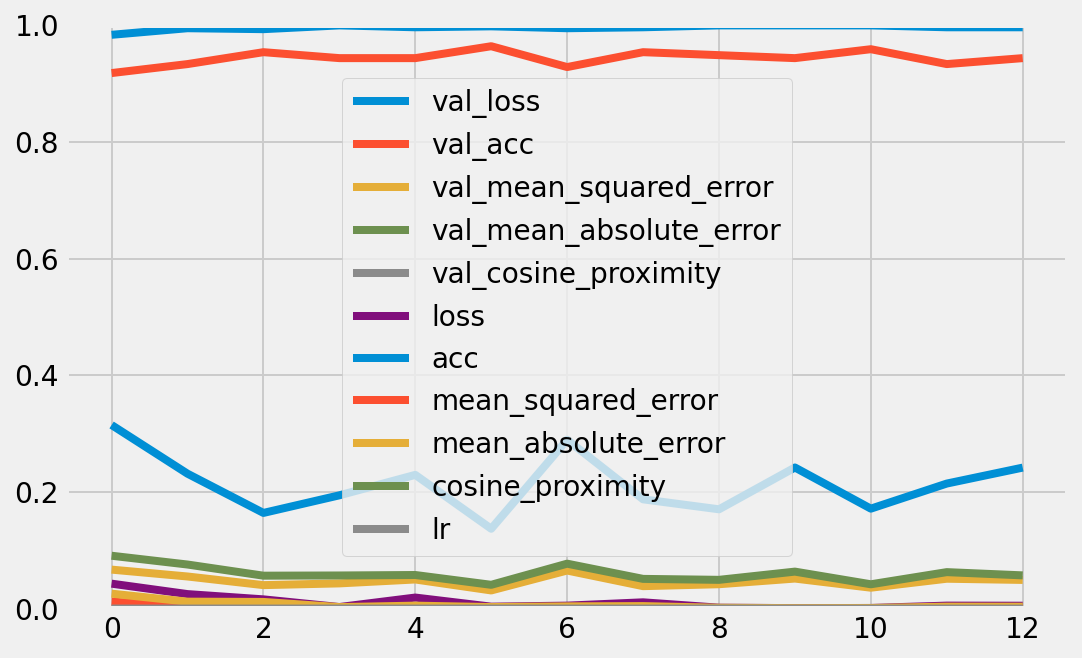

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

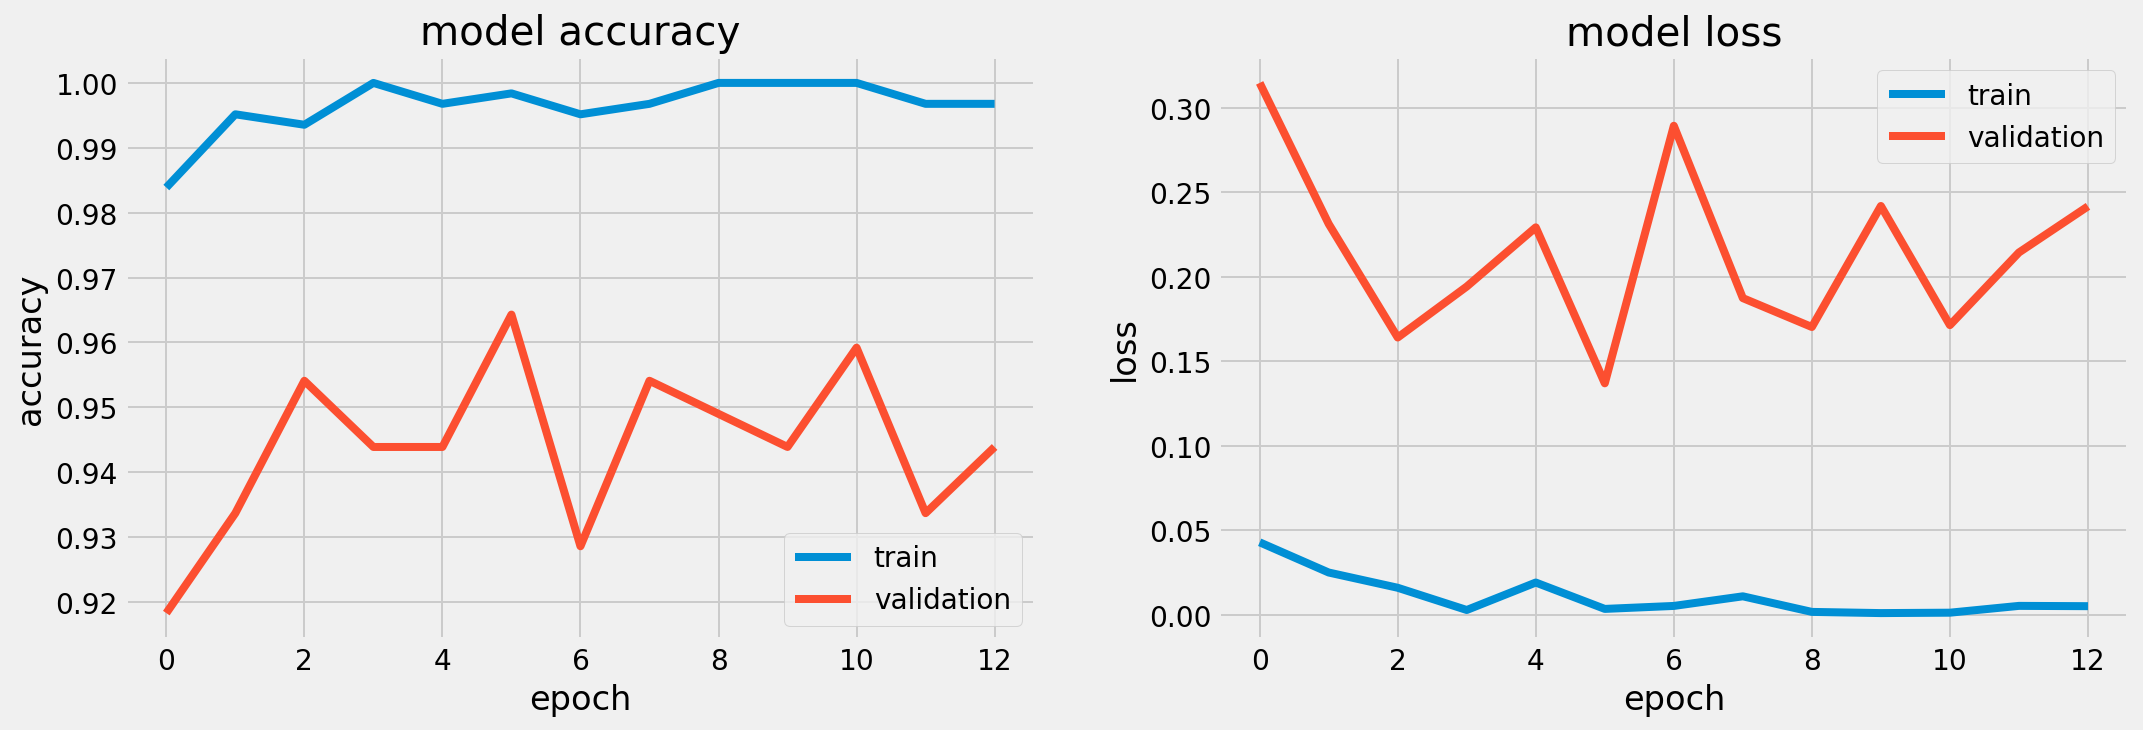

In [39]:
plt.figure(figsize=(16,5))
plt.subplot(121)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

plt.show()

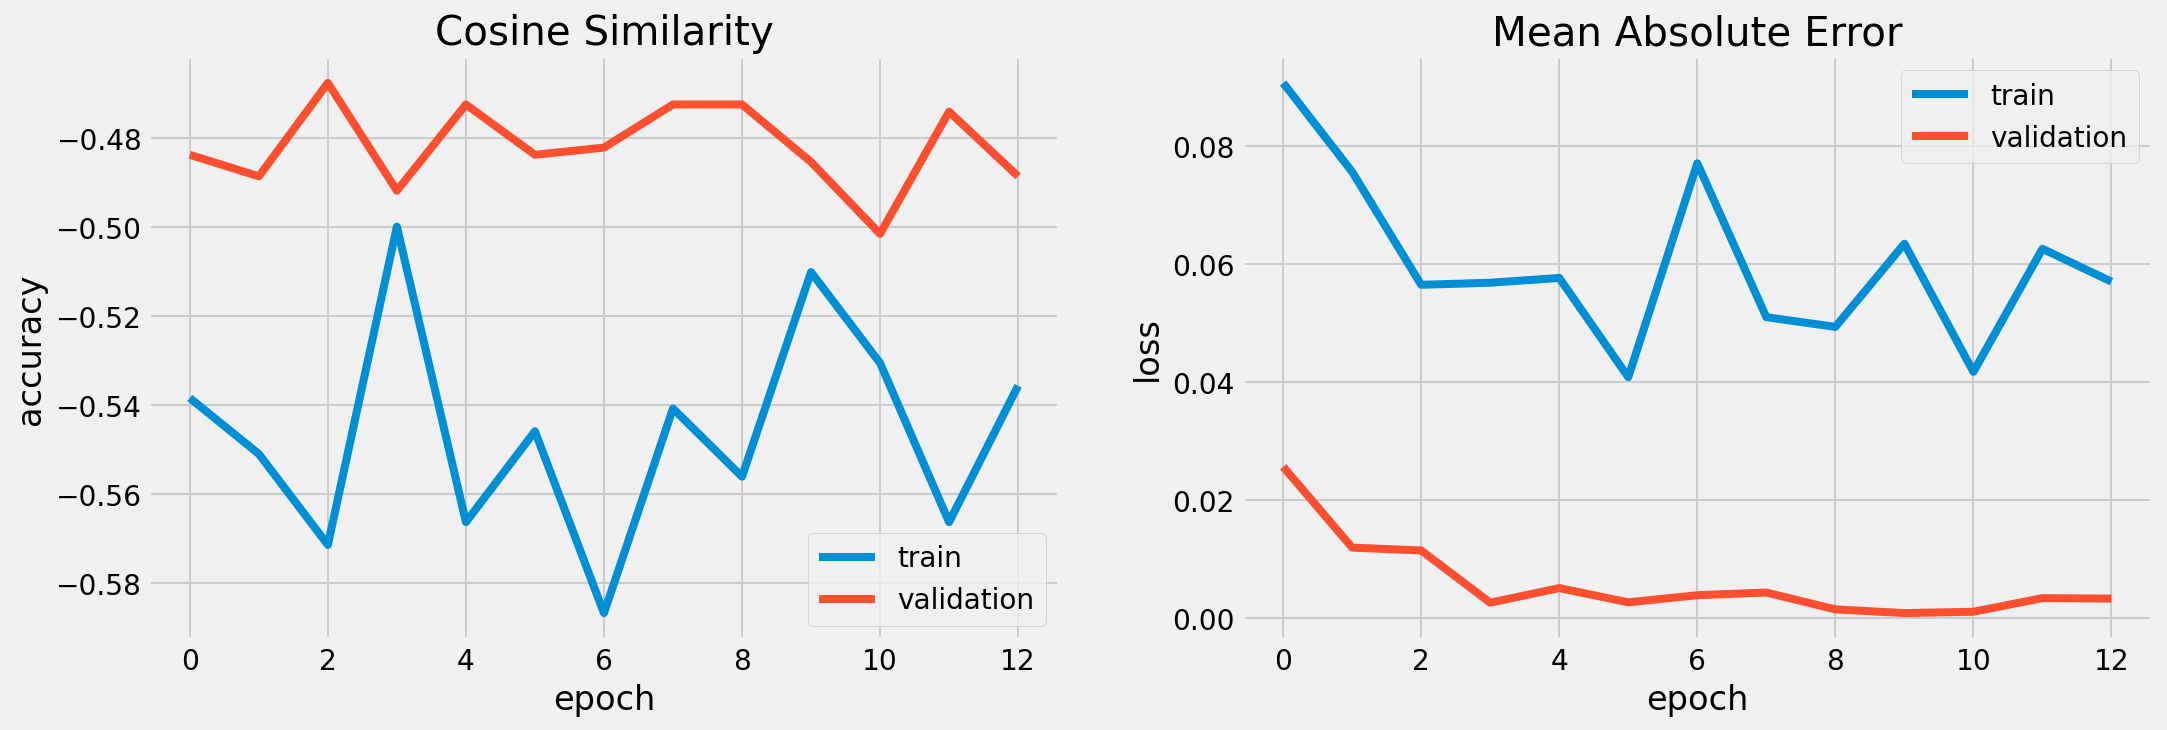

In [40]:
plt.figure(figsize=(16,5))
plt.subplot(121)
plt.plot(history.history['val_cosine_proximity'])
plt.plot(history.history['cosine_proximity'])
plt.title('Cosine Similarity')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.subplot(122)
plt.plot(history.history['val_mean_absolute_error'])
plt.plot(history.history['mean_absolute_error'])
plt.title('Mean Absolute Error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

plt.show()

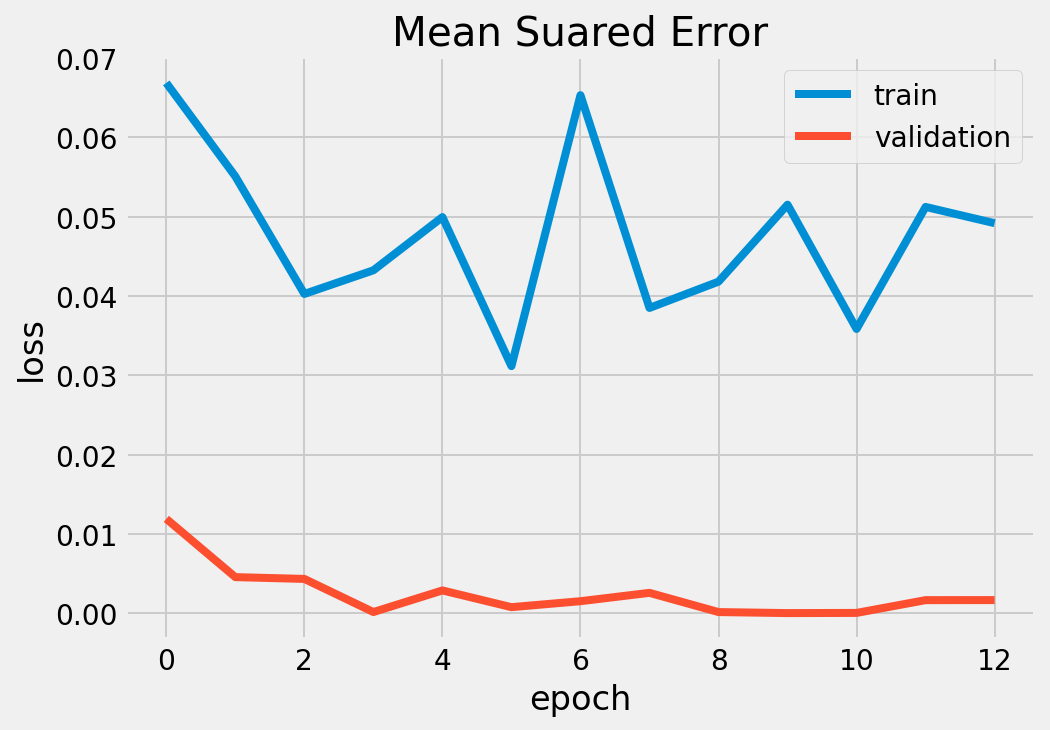

In [41]:
plt.figure(figsize=(16,5))
plt.subplot(122)
plt.plot(history.history['val_mean_squared_error'])
plt.plot(history.history['mean_squared_error'])
plt.title('Mean Suared Error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

plt.show()